
# Dynamic Causal Effects Estimation with Bayesian LSTM

This notebook demonstrates a project for estimating dynamic causal effects using an approximated Bayesian LSTM. The goal is to model the causal impact of policies or events over time, with an emphasis on counterfactual scenario analysis. 

The code focuses on using time-series data to estimate causal effects via:
1. Time series preprocessing.
2. Bayesian LSTM construction and training.
3. Counterfactual simulations.
4. Visualisation and evaluation.

---
### Libraries Used


In [ ]:

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

# Key libraries:
# - `numpy`, `pandas` for data manipulation
# - `matplotlib` for visualisation
# - `torch` for constructing and training the Bayesian LSTM model
# - `sklearn` for scaling and preprocessing data



## Data Plot

In this section, the time series data is plotted to visualise patterns and trends. This helps in understanding the dataset before preprocessing.


<ipython-input-225-ece72d0dfdab>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-225-ece72d0dfdab>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-225-ece72d0dfdab>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



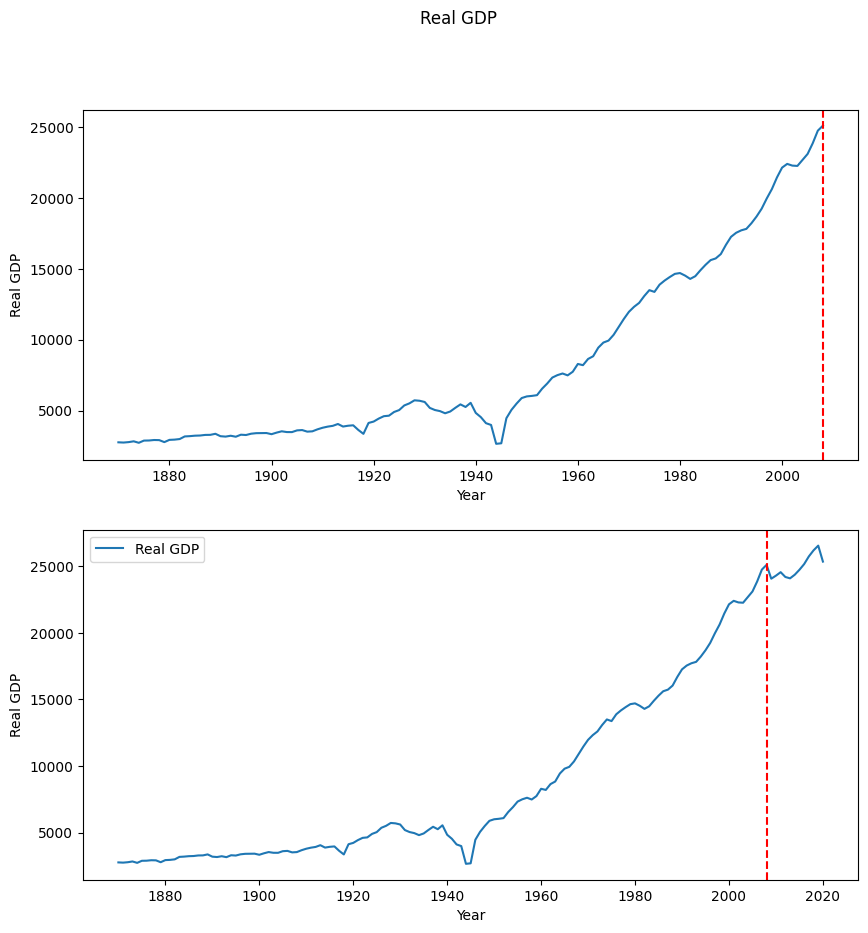

In [ ]:
macro_dataset = pd.read_excel('/content/JSTdatasetR6.xlsx')
usa = macro_dataset[macro_dataset['country'] == 'Netherlands']
variables = ['year', 'rgdpmad']
usa_dataset = usa[variables]
usa_dataset['year'] = pd.to_numeric(usa_dataset['year'], errors='coerce')
usa_dataset['year'] = pd.to_datetime(usa_dataset['year'], format = '%Y')
usa_dataset.set_index('year', inplace=True)
usa_dataset.dropna(inplace=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
training_set = usa_dataset[usa_dataset.index <= pd.to_datetime("2008-01-01")]
training_set_extra = usa_dataset[usa_dataset.index <= pd.to_datetime("2008-01-01")]
# input: 1870 - 2007 (138), output: 1874 - 2007 (134).
counterfactual_set_plot = usa_dataset[usa_dataset.index > pd.to_datetime("2003-01-01")]
# input: 2004 - 2020 (17), output: 2008 - 2020 (13)
counterfactual_set = usa_dataset
# input: 1870 - 2020 (151), output: 1874 - 2020 (147)
ax1.plot(training_set, label = 'Real GDP')
#ax1.plot(counterfactual_set_plot, label = 'Real GDP')
ax2.plot(usa_dataset, label='Real GDP')
ax1.axvline(x=pd.to_datetime("2008-01-01"), c='r', linestyle='--')
ax2.axvline(x=pd.to_datetime("2008-01-01"), c='r', linestyle='--')

fig.suptitle('Real GDP')

ax1.set_xlabel('Year')
ax1.set_ylabel('Real GDP')

ax2.set_xlabel('Year')
ax2.set_ylabel('Real GDP')

#plt.savefig('RealGDP.png', format = 'png')
plt.legend()
#plt.show()

In [ ]:
#counterfactual_set_plot.index.dtype
#counterfactual_set_plot.loc[pd.to_datetime("2008-01-01"):]['rgdpmad']

In [ ]:
import plotly.graph_objects as go
training_set_plot = go.Scatter(x=training_set_extra.index, y=training_set_extra['rgdpmad'], mode='lines', name='Training Period')
counterfactual_set_plotly = go.Scatter(x=counterfactual_set_plot.loc[pd.to_datetime("2008-01-01"):].index, y=counterfactual_set_plot.loc[pd.to_datetime("2008-01-01"):]['rgdpmad'], mode='lines', name='Counterfactual Period')

data_plot = [training_set_plot, counterfactual_set_plotly]
fig = go.Figure(data=data_plot)

fig.add_shape(
    dict(
        type="line",
        x0='2008-01-01', x1='2008-01-01',  # Date where the line should be
        y0=0, y1=1,  # Spanning the entire y-axis, from 0 to 1 in relative terms
        xref='x', yref='paper',  # x is date, y is relative to the paper (0 to 1)
        line=dict(color="red", width=2, dash="dash")
    )
)

fig.update_layout(title='Real GDP',
                   xaxis_title='Year',
                   yaxis_title='Real GDP ($PPP)')

fig.show()

In [ ]:
usa_dataset.reset_index(inplace=True)
#usa_dataset

### **Data Preprocessing: Sliding Window and Scaling**

This section focuses on preparing time-series data for training, testing, and counterfactual analysis, ensuring the data is formatted and scaled appropriately for the Bayesian LSTM model. The steps include:

1. **Sliding Window Function**  
   Converts sequential data into supervised learning pairs:
   - **Input (\(X\))**: A sequence of `seq_length` values.
   - **Output (\(Y\))**: The value immediately following the sequence.

2. **Data Scaling**  
   Normalises datasets using `MinMaxScaler` to scale values to the range [0, 1], which improves model performance and stability:
   - Applies to the training dataset, counterfactual data, and the full dataset for counterfactual evaluations.

3. **Train-Test Split**  
   Divides the training dataset into:
   - **Training set**: 95% of the data.
   - **Testing set**: The remaining 5%, reserved for validation.

4. **Conversion to PyTorch Tensors**  
   Converts the preprocessed data into PyTorch `Variable` tensors to ensure compatibility with the LSTM model.

---

This preprocessing workflow ensures that the time-series data is segmented, scaled, and formatted for robust training and counterfactual analysis.


In [ ]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)
counterfactual_data = sc.transform(counterfactual_set_plot)
counterfactual_set_transformed = sc.transform(usa_dataset[['rgdpmad']])

seq_length = 4
x, y = sliding_windows(training_data, seq_length) # input: 1870 - 2007 (137), output: 1874 - 2007 (133).
X, Y = sliding_windows(counterfactual_data, seq_length) # input: 2004 - 2020 (16), output: 2008 - 2020 (12)
_x, _y = sliding_windows(counterfactual_set_transformed, seq_length) # input: 1870 - 2020 (150), output: 1874 - 2020 (146)

train_size = int(len(y) * 0.95)
test_size = len(y) - train_size

datax = Variable(torch.Tensor(np.array(x))) # input: 1870 - 2007 (137), output: 1874 - 2007 (133).
datay = Variable(torch.Tensor(np.array(y))) # input: 1870 - 2007 (137), output: 1874 - 2007 (133).
dataX = Variable(torch.Tensor(np.array(X))) # input: 2004 - 2020 (16), output: 2008 - 2020 (12)
dataY = Variable(torch.Tensor(np.array(Y))) # input: 2004 - 2020 (16), output: 2008 - 2020 (12)
data_x = Variable(torch.Tensor(np.array(_x))) # input: 1870 - 2020 (150), output: 1874 - 2020 (146)
data_y = Variable(torch.Tensor(np.array(_y))) # input: 1870 - 2020 (150), output: 1874 - 2020 (146)

trainX = Variable(torch.Tensor(np.array(x[0:train_size]))) # 126
trainY = Variable(torch.Tensor(np.array(y[0:train_size]))) # 126

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)]))) # 7
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)]))) #7

### **LSTM Model Definition**

This section defines the Long Short-Term Memory (LSTM) neural network architecture for modelling time-series data. The network is designed to handle sequential input, learn temporal patterns, and produce predictions for dynamic causal analysis. Key components of the model are described below:

1. **Class Initialization**  
   The `LSTM` class is a PyTorch implementation of an LSTM model with the following attributes:
   - `output_size`: Number of output features (e.g., single-step prediction).
   - `input_size`: Number of input features per time step.
   - `hidden_size`: Number of units in the LSTM's hidden layers.
   - `num_layers`: Number of stacked LSTM layers.
   - `dropout_prob`: Dropout probability for regularisation.

2. **LSTM Layer**  
   The `nn.LSTM` layer is the core of the model, processing sequential input data and maintaining memory of past time steps. It supports multi-layer configurations.

3. **Dropout Layer**  
   A dropout layer is applied after the LSTM to prevent overfitting by randomly setting some activations to zero during training.

4. **Fully Connected Layer**  
   The `nn.Linear` layer maps the LSTM's hidden state to the desired output size.

5. **Forward Pass**  
   The `forward` method processes the input data through:
   - Initialising hidden (\( h_0 \)) and cell states (\( c_0 \)).
   - Passing the input sequence through the LSTM layer.
   - Applying dropout to the LSTM's output.
   - Producing predictions using the fully connected layer.

This architecture is modular, flexible, and well-suited for capturing temporal dependencies in time-series data.


In [ ]:
class LSTM(nn.Module):

    def __init__(self, output_size, input_size, hidden_size, num_layers, dropout_prob):
        super(LSTM, self).__init__()

        self.output_size = output_size
        self.dropout_prob = dropout_prob
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=self.dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = self.dropout(h_out[-1, :, :])

        out = self.fc(h_out)

        return out

## Training

In [ ]:
num_epochs = 3000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1
output_size = 1
dropout_prob = 0.01

lstm = LSTM(output_size, input_size, hidden_size, num_layers, dropout_prob)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

lstm.eval()
# Train the model
for epoch in range(num_epochs+1):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.36077
Epoch: 100, loss: 0.04997
Epoch: 200, loss: 0.00165
Epoch: 300, loss: 0.00050
Epoch: 400, loss: 0.00039
Epoch: 500, loss: 0.00034
Epoch: 600, loss: 0.00031
Epoch: 700, loss: 0.00029
Epoch: 800, loss: 0.00027
Epoch: 900, loss: 0.00025
Epoch: 1000, loss: 0.00023
Epoch: 1100, loss: 0.00021
Epoch: 1200, loss: 0.00019
Epoch: 1300, loss: 0.00018
Epoch: 1400, loss: 0.00017
Epoch: 1500, loss: 0.00016
Epoch: 1600, loss: 0.00016
Epoch: 1700, loss: 0.00016
Epoch: 1800, loss: 0.00016
Epoch: 1900, loss: 0.00016
Epoch: 2000, loss: 0.00016
Epoch: 2100, loss: 0.00015
Epoch: 2200, loss: 0.00015
Epoch: 2300, loss: 0.00015
Epoch: 2400, loss: 0.00015
Epoch: 2500, loss: 0.00015
Epoch: 2600, loss: 0.00015
Epoch: 2700, loss: 0.00015
Epoch: 2800, loss: 0.00015
Epoch: 2900, loss: 0.00015
Epoch: 3000, loss: 0.00015


## Testing

In [ ]:
lstm.eval()
train_predict = lstm(datax)
# 1874 - 2007
counterfactual_predict = lstm(dataX)
# 2008 - 2020

data_predict = train_predict.data.numpy()
counterfactual_predict = counterfactual_predict.data.numpy()
datay_plot_it = datay.data.numpy()
dataY_plot_it = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
counterfactual_predict = sc.inverse_transform(counterfactual_predict)
datay_plot = sc.inverse_transform(datay_plot_it)
dataY_plot = sc.inverse_transform(dataY_plot_it)

In [ ]:
merged_counterfactual = np.vstack((data_predict, counterfactual_predict))
merged_ground_truth = np.vstack((datay_plot, dataY_plot))

merged_counterfactual = pd.DataFrame(merged_counterfactual, columns = ['rgdpmad'])
merged_ground_truth = pd.DataFrame(merged_ground_truth, columns = ['rgdpmad'])
data_predict = pd.DataFrame(data_predict, columns = ['rgdpmad'])

In [ ]:
merged_counterfactual['date'] = usa_dataset[(pd.to_datetime("1874-01-01") < usa_dataset['year'])]['year']
merged_ground_truth['date'] = usa_dataset[(pd.to_datetime("1874-01-01") < usa_dataset['year'])]['year']
data_predict['date'] = usa_dataset[(pd.to_datetime("1874-01-01") < usa_dataset['year']) & (usa_dataset['year'] < pd.to_datetime("2007-01-01"))]['year']

merged_ground_truth.dropna(inplace=True)
merged_counterfactual.dropna(inplace=True)
data_predict.dropna(inplace=True)

In [ ]:
mse_loss_fn = nn.MSELoss()

# Set the model to evaluation mode
lstm.eval()

# Disable gradient computation
with torch.no_grad():
    # Make predictions on the test set
    predictions = lstm(datax)
    datay_plot_tensor = torch.from_numpy(datay_plot_it).float()
    # Calculate the Mean Squared Error loss
    mse_loss = mse_loss_fn(predictions, datay_plot_tensor)

    # Print the MSE loss value
    print(f"Mean Squared Error Loss: {mse_loss.item()}")

Mean Squared Error Loss: 0.0002104558952851221


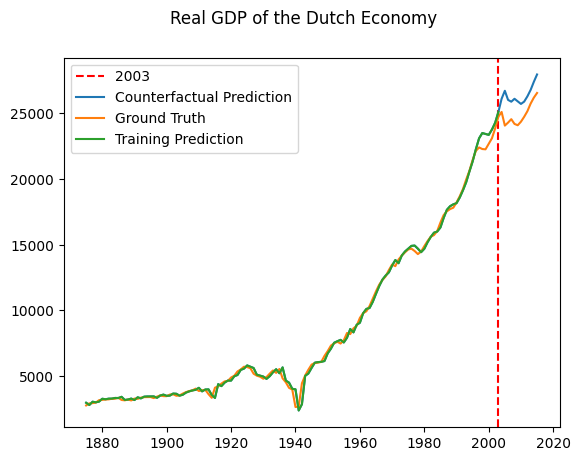

In [ ]:

# Plot the time-series data
plt.plot(time_series, label='Original Data')
plt.title("Time Series Data Visualization")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()


### **Monte Carlo Dropout for Uncertainty Estimation**

This section estimates uncertainty in predictions by leveraging Monte Carlo (MC) dropout during evaluation. By running multiple forward passes with enabled dropout, the variability in predictions can be quantified. Key steps are outlined below:

1. **Number of Experiments**  
   - `n_experiments`: The number of stochastic forward passes (50,000 in this case).

2. **DataFrames for Results**  
   - `test_uncertainty_df` and `counterfactual_uncertainty_df` are initialised to store predictions and uncertainty metrics for the test data and counterfactual scenarios, respectively.

3. **Enable Dropout During Evaluation**  
   - The `enable_dropout(model)` function forces dropout layers to remain active during evaluation mode, allowing stochasticity in predictions.

4. **Monte Carlo Simulations**  
   - For each experiment:
     1. Dropout is enabled for the LSTM model.
     2. Predictions are made for:
        - `datax`: Test data.
        - `dataX`: Counterfactual data.
     3. Predictions are stored in their respective DataFrames after being inverse-transformed to the original scale.

5. **Uncertainty Quantification**  
   - For each time step:
     - **Mean Prediction**: Calculated across all experiments for a given time step.
     - **Standard Deviation**: Represents the uncertainty in predictions.
   - These metrics are stored as `real_gdp_mean` and `real_gdp_std`.

6. **Date Alignment**  
   - `date` columns are added to align predictions with their corresponding years in the test and counterfactual datasets.

7. **Cleaned DataFrames**  
   - For the test data, missing values are dropped, and the DataFrame is reset for further analysis.
   - The counterfactual DataFrame retains its structure for evaluating scenarios.

This approach provides both point estimates and confidence intervals for predictions, making the model's outputs interpretable and suitable for causal inference in dynamic scenarios.


In [ ]:
n_experiments = 50000

test_uncertainty_df = pd.DataFrame(index=range(datax.shape[0]))
counterfactual_uncertainty_df = pd.DataFrame(index=range(dataX.shape[0]))

def enable_dropout(model):
    """ Function to enable the dropout layers during test-time (evaluation mode) """
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()

for i in range(n_experiments):
  enable_dropout(lstm)
  experiment_predictions = lstm(datax)
  counterfactual_predictions = lstm(dataX)
  test_uncertainty_df['real_gdp_{}'.format(i)] = sc.inverse_transform(experiment_predictions.detach().numpy())#.squeeze())
  counterfactual_uncertainty_df['real_gdp_{}'.format(i)] = sc.inverse_transform(counterfactual_predictions.detach().numpy())#.squeeze())

test_uncertainty_df['real_gdp_mean'] = test_uncertainty_df.filter(like='real_gdp_', axis=1).mean(axis=1)
test_uncertainty_df['real_gdp_std'] = test_uncertainty_df.filter(like='real_gdp_', axis=1).std(axis=1)
test_uncertainty_df['date'] = usa_dataset[(pd.to_datetime("1870-01-01") <= usa_dataset['year']) & (usa_dataset['year'] <= pd.to_datetime("2008-01-01"))]['year']

test_uncertainty_df = test_uncertainty_df[['date', 'real_gdp_mean', 'real_gdp_std']]
test_uncertainty_df.dropna(inplace=True)
test_uncertainty_df.reset_index(drop=True, inplace=True)
#test_uncertainty_df

counterfactual_uncertainty_df['real_gdp_mean'] = counterfactual_uncertainty_df.filter(like='real_gdp_', axis=1).mean(axis=1)
counterfactual_uncertainty_df['real_gdp_std'] = counterfactual_uncertainty_df.filter(like='real_gdp_', axis=1).std(axis=1)
counterfactual_uncertainty_df['date'] = merged_counterfactual['date'][-12:]

counterfactual_uncertainty_df = counterfactual_uncertainty_df[['date', 'real_gdp_mean', 'real_gdp_std']]
#counterfactual_uncertainty_df.dropna(inplace=True)
#counterfactual_uncertainty_df.reset_index(drop=True, inplace=True)


Streaming output truncated to the last 5000 lines.

<ipython-input-500-aeb6467f8e59>:16: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-500-aeb6467f8e59>:17: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-500-aeb6467f8e59>:16: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [ ]:
dates = pd.date_range(start='2003-01-01', end='2014-01-01', freq='YS')
date_df = pd.DataFrame({'date': dates}, index=range(133, 145))
counterfactual_uncertainty_df['date'] = date_df['date']

# Check if the length of the DataFrame matches the length of the date range
if len(counterfactual_uncertainty_df) == len(dates):
    counterfactual_uncertainty_df['date'] = dates
else:
    print(f"Length mismatch: {len(counterfactual_uncertainty_df)} rows vs {len(dates)} dates")

In [ ]:
# 3 standard deviations for 99% uncertainty interval
test_uncertainty_df['lower_bound'] = test_uncertainty_df['real_gdp_mean'] - 3*test_uncertainty_df['real_gdp_std']
test_uncertainty_df['upper_bound'] = test_uncertainty_df['real_gdp_mean'] + 3*test_uncertainty_df['real_gdp_std']

counterfactual_uncertainty_df['lower_bound'] = counterfactual_uncertainty_df['real_gdp_mean'] - 3*counterfactual_uncertainty_df['real_gdp_std']
counterfactual_uncertainty_df['upper_bound'] = counterfactual_uncertainty_df['real_gdp_mean'] + 3*counterfactual_uncertainty_df['real_gdp_std']

In [ ]:
test_uncertainty_plot_df = test_uncertainty_df.copy(deep=True)
counterfactual_uncertainty_plot_df = counterfactual_uncertainty_df.copy(deep=True)
truth_uncertainty_plot_df = counterfactual_set.copy(deep=True)
truth_uncertainty_plot_df.index.name = 'date'
truth_uncertainty_plot_df.reset_index(inplace=True)

In [ ]:
truth_uncertainty_2015 = truth_uncertainty_plot_df[truth_uncertainty_plot_df['year'] <= pd.to_datetime('2015-01-01')]

In [ ]:
import plotly.graph_objects as go

upper_trace = go.Scatter(
    x=test_uncertainty_plot_df['date'],
    y=test_uncertainty_plot_df['upper_bound'],
    mode='lines',
    fill=None,
    name='99% Upper Uncertainty Bound (Training)'
    )
lower_trace = go.Scatter(
    x=test_uncertainty_plot_df['date'],
    y=test_uncertainty_plot_df['lower_bound'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255, 211, 0, 0.1)',
    name='99% Lower Uncertainty Bound (Training)'
    )
training_mean = go.Scatter(
    x=test_uncertainty_plot_df['date'],
    y=test_uncertainty_plot_df['real_gdp_mean'],
    mode='lines',
    fill=None,
    name='Training Mean'
    )
real_trace = go.Scatter(
    x=truth_uncertainty_2015['year'],
    y=truth_uncertainty_2015['rgdpmad'],
    mode='lines',
    fill=None,
    name='Real Values'
    )
counterfactual_uncertainty = go.Scatter(
    x=counterfactual_uncertainty_plot_df['date'],
    y=counterfactual_uncertainty_plot_df['real_gdp_mean'],
    mode='lines',
    fill=None,
    name='Counterfactual Values'
)
upper_trace_cf = go.Scatter(
    x=counterfactual_uncertainty_plot_df['date'],
    y=counterfactual_uncertainty_plot_df['upper_bound'],
    mode='lines',
    fill=None,
    name='99% Upper Confidence Bound'
    )
lower_trace_cf = go.Scatter(
    x=counterfactual_uncertainty_plot_df['date'],
    y=counterfactual_uncertainty_plot_df['lower_bound'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255, 211, 0, 0.1)',
    name='99% Lower Confidence Bound'
    )

data = [upper_trace, lower_trace, real_trace, counterfactual_uncertainty, training_mean, upper_trace_cf, lower_trace_cf]

fig = go.Figure(data=data)

fig.add_shape(
    dict(
        type="line",
        x0='2008-01-01', x1='2008-01-01',
        y0=0, y1=1,
        xref='x', yref='paper',
        line=dict(color="red", width=2, dash="dash")
    )
)

fig.update_layout(title='Uncertainty Quantification for Real GDP',
                   xaxis_title='Year',
                   yaxis_title='Real GDP ($PPP)')

#fig.show()

In [ ]:
# Graph in plotly
merged_ground_truth_plot = go.Scatter(x=merged_ground_truth['date'], y=merged_ground_truth['rgdpmad'], mode='lines', name='Ground Truth')
training_mean = go.Scatter(
    x=test_uncertainty_plot_df['date'],
    y=test_uncertainty_plot_df['real_gdp_mean'],
    mode='lines',
    fill=None,
    name='Training Mean'
    )
counterfactual_uncertainty = go.Scatter(
    x=counterfactual_uncertainty_plot_df['date'],
    y=counterfactual_uncertainty_plot_df['real_gdp_mean'],
    mode='lines',
    fill=None,
    name='Counterfactual Values'
)
upper_trace_cf = go.Scatter(
    x=counterfactual_uncertainty_plot_df['date'],
    y=counterfactual_uncertainty_plot_df['upper_bound'],
    mode='lines',
    fill=None,
    name='99% Upper Uncertainty Bound (Counterfactual)'
    )
lower_trace_cf = go.Scatter(
    x=counterfactual_uncertainty_plot_df['date'],
    y=counterfactual_uncertainty_plot_df['lower_bound'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255, 211, 0, 0.1)',
    name='99% Lower Uncertainty Bound (Counterfactual)'
    )

data_first = [merged_ground_truth_plot, upper_trace, lower_trace, counterfactual_uncertainty, upper_trace_cf, lower_trace_cf, training_mean]

fig = go.Figure(data=data_first)

fig.add_shape(
    dict(
        type="line",
        x0='2003-01-01', x1='2003-01-01',
        y0=0, y1=1,
        xref='x', yref='paper',
        line=dict(color="red", width=2, dash="dash")
    )
)

fig.update_layout(title='Counterfactual Prediction for Real GDP vs Ground Truth With 99% Uncertainty Intervals',
                   xaxis_title='Year',
                   yaxis_title='Real GDP per capita (PPP, 1990 Int$, Maddison)')
fig.show()

In [ ]:
merged_ground_truth_plot_training = merged_ground_truth[merged_ground_truth['date'] <= pd.to_datetime('2008-01-01')]
merged_ground_truth_plot_training.reset_index(drop=True, inplace=True)

In [ ]:
counterfactual_uncertainty_plot_df
truth_uncertainty_new = truth_uncertainty_2015[-12:]
truth_uncertainty_new.drop(columns=['year', 'date'], inplace=True)
truth_uncertainty_new.reset_index(drop=True, inplace=True)
truth_uncertainty_new['year'] = counterfactual_uncertainty_plot_df['date']
counterfactual_uncertainty_plot_df['point_wise'] = truth_uncertainty_new['rgdpmad'] - counterfactual_uncertainty_plot_df['real_gdp_mean']
counterfactual_uncertainty_plot_df['cumulative'] = counterfactual_uncertainty_plot_df['point_wise'].cumsum()

<ipython-input-509-48de346a577c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-509-48de346a577c>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=counterfactual_uncertainty_plot_df['date'], y=counterfactual_uncertainty_plot_df['point_wise'],
    mode='lines+markers',
    name='Point Wise',
    line=dict(color='firebrick', width=2)
))

fig.add_trace(go.Scatter(
    x=counterfactual_uncertainty_plot_df['date'], y=counterfactual_uncertainty_plot_df['cumulative'],
    mode='lines+markers',
    name='Cumulative',
    line=dict(color='royalblue', width=2)
))

fig.update_layout(
    title='Point Wise and Cumulative Causal Effects Over Time',
    xaxis_title='Date',
    yaxis_title='Decline in Real GDP per capia (PPP, 1990 Int$, Maddison)',
    hovermode='x unified'
)

fig.show()

In [ ]:
results = pd.concat((counterfactual_uncertainty_plot_df['real_gdp_mean'], truth_uncertainty_new['rgdpmad']), axis = 1)
#results

In [ ]:
# prompt: Using dataframe results: percentage difference

# Calculate the percentage difference between 'real_gdp_mean' and 'rgdpmad'
results['percentage_difference'] = ((results['real_gdp_mean'] - results['rgdpmad']) / results['rgdpmad']) * 100

# Display the DataFrame with the new column
#results

In [ ]:
causal_effects = counterfactual_uncertainty_plot_df[['date','point_wise', 'cumulative', 'upper_bound', 'lower_bound']]
causal_effects = pd.concat([causal_effects, results], axis=1)
causal_effects

,date,point_wise,cumulative,upper_bound,lower_bound,real_gdp_mean,rgdpmad,percentage_difference
0,2003-01-01,-3407.599809,-3407.599809,30243.542969,21963.308594,26103.425781,22695.825972,15.014214
1,2004-01-01,-3615.177793,-7022.777602,31069.171875,22388.656250,26728.914062,23113.736270,15.640820
2,2005-01-01,-2160.100550,-9182.878152,30074.074219,21980.148438,26027.111328,23867.010778,9.050570
3,2006-01-01,-1133.604360,-10316.482512,29939.824219,21840.109375,25889.966797,24756.362437,4.579043
4,2007-01-01,-991.348629,-11307.831141,30228.601562,21978.718750,26103.660156,25112.311528,3.947660
5,2008-01-01,-1858.014203,-13165.845344,29853.144531,22009.714844,25931.429688,24073.415484,7.718116
6,2009-01-01,-1424.893760,-14590.739104,29636.978516,21818.044922,25727.511719,24302.617959,5.863129
7,2010-01-01,-1332.391795,-15923.130900,29960.111328,21832.525391,25896.318359,24563.926564,5.424181
8,2011-01-01,-2105.510124,-18028.641023,30418.392578,22197.166016,26307.779297,24202.269173,8.699639
9,2012-01-01,-2702.339827,-20730.980851,30814.035156,22791.914062,26802.974609,24100.634782,11.212733


In [ ]:
ut_df, lt_df, rt_df = pd.DataFrame(upper_trace['y'], columns=['upper_trace']), pd.DataFrame(lower_trace['y'], columns=['lower_trace']), pd.DataFrame(real_trace['y'], columns=['real_trace'])

In [ ]:
total_trace = pd.concat([ut_df, lt_df, rt_df], axis=1)
total_trace.dropna(inplace=True)

In [ ]:
ground_truth = merged_ground_truth['rgdpmad'][:len(test_uncertainty_plot_df['lower_bound'])]
ground_truth = ground_truth.to_frame()
ground_truth.reset_index(inplace=True)

In [ ]:
datay_plot_df = pd.DataFrame(datay_plot.flatten(), columns=['real_trace'])

In [ ]:
#picp = 1 / total_trace.shape[0] * (total_trace[(total_trace['real_trace'] <= total_trace['upper_trace']) & (total_trace['real_trace'] >= total_trace['lower_trace'])].sum())
def picp(y_true, y_lower, y_upper):
    """
    Calculate Prediction Interval Coverage Probability (PICP).

    Parameters:
    y_true (numpy array): True values.
    y_lower (numpy array): Lower bound of prediction intervals.
    y_upper (numpy array): Upper bound of prediction intervals.

    Returns:
    float: PICP value.
    """
    N = len(y_true)
    inside_interval = np.logical_and(y_true >= y_lower, y_true <= y_upper)
    picp_value = np.sum(inside_interval) / N
    return picp_value

picp_value = picp(datay_plot_df['real_trace'],total_trace['lower_trace'], total_trace['upper_trace'])
print(f"PICP: {picp_value:.4f}")

PICP: 1.0000


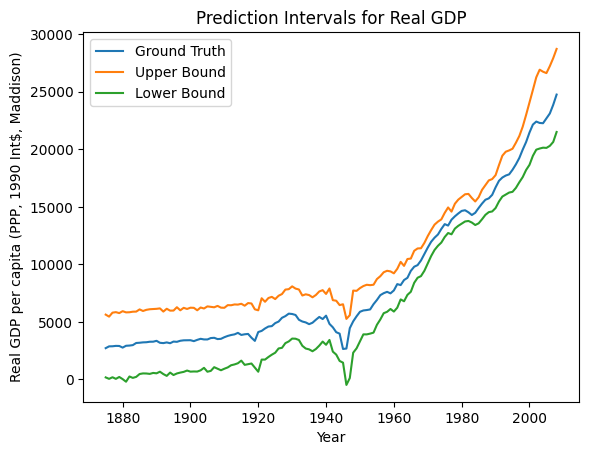

In [ ]:

# Plot the time-series data
plt.plot(time_series, label='Original Data')
plt.title("Time Series Data Visualization")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()


In [ ]:
def mpiw(y_lower, y_upper):
    """
    Calculate Mean Prediction Interval Width (MPIW).

    Parameters:
    y_lower (numpy array): Lower bound of prediction intervals.
    y_upper (numpy array): Upper bound of prediction intervals.

    Returns:
    float: MPIW value.
    """
    return np.mean(y_upper - y_lower)

def cwc(y_true, y_lower, y_upper, picp_value, target_picp=0.95, penalty=50):
    """
    Calculate Coverage Width-Based Criterion (CWC).

    Parameters:
    y_true (numpy array): True values.
    y_lower (numpy array): Lower bound of prediction intervals.
    y_upper (numpy array): Upper bound of prediction intervals.
    picp_value (float): The calculated PICP value.
    target_picp (float): The target PICP value (default is 0.95).
    penalty (float): Penalty factor for failing to meet target PICP.

    Returns:
    float: CWC value.
    """
    N = len(y_true)
    mpiw_value = mpiw(y_lower, y_upper)
    penalty_term = penalty * np.max([0, target_picp - picp_value])
    cwc_value = mpiw_value * (1 + penalty_term)
    return cwc_value

mpiw_value = mpiw(total_trace['lower_trace'], total_trace['upper_trace'])
print(f"MPIW: {mpiw_value:.4f}")

cwc_value = cwc(total_trace['real_trace'], total_trace['lower_trace'], total_trace['upper_trace'], picp_value)
print(f"CWC: {cwc_value:.4f}")

MPIW: 4490.2490
CWC: 4490.2490



---
## How to Run this Notebook

1. Ensure all dependencies (`numpy`, `torch`, etc.) are installed.
2. Prepare the time-series data in the required format.
3. Run each section sequentially to preprocess data, train the model, and visualise results.
4. Modify parameters in the Bayesian LSTM model or preprocessing steps to adapt the notebook for specific datasets or tasks.

---
This notebook is part of a project exploring advanced methods in causal inference and machine learning. Contributions are welcome!
    